In [19]:
import torch
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [20]:
valid_data,train_data,test_data = torch.load("Fold1_data")
valid_targ,train_targ,test_targ = torch.load("Fold1_targ")
print(valid_data.shape,train_data.shape,test_data.shape)
print(valid_targ.shape,train_targ.shape,test_targ.shape)

torch.Size([21, 102, 1024]) torch.Size([279, 102, 1024]) torch.Size([21, 102, 1024])
torch.Size([21, 100]) torch.Size([279, 100]) torch.Size([21, 100])


In [21]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

seq_len = train_data.size(1)
seq_feat = train_data.size(2)
num_seq = train_data.size(0)

class Net(nn.Module):
    def __init__(self, input_channels):
        super(Net, self).__init__()
        self.input_channels = input_channels
        
        self.conv1 = nn.Conv1d(in_channels = input_channels,
                               out_channels = 10, # size output
                               kernel_size = 65,
                              padding = 32)
        
        self.conv2 = nn.Conv1d(in_channels = input_channels,
                               out_channels = 10, # size output
                               kernel_size = 129,
                              padding = 64) 
        
        self.conv3 = nn.Conv1d(in_channels = 20,
                               out_channels = 10, # size output
                               kernel_size = 3)
        
        self.lstm = nn.LSTM(input_size=10,
                             hidden_size=50,
                             num_layers=1,
                             batch_first=True)
        
        self.fc_1 = nn.Linear(50,1)
        
        #self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
                
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x2 = self.conv2(x)
        x2 = F.relu(x2)
        x = torch.cat((x1,x2),1)
        
        x = self.conv3(x)
        x = torch.transpose(x,1,2)
        
        #print("x: ",x.size())
        
        out,(h,c) = self.lstm(x)
        
        #print("out: ",out.size())
        #print("h: ",h.size())
        #print("c: ",c.size())
        x = self.fc_1(out)
        
        return x.squeeze(-1)
    
net = Net(seq_feat)
print(net)

Net(
  (conv1): Conv1d(1024, 10, kernel_size=(65,), stride=(1,), padding=(32,))
  (conv2): Conv1d(1024, 10, kernel_size=(129,), stride=(1,), padding=(64,))
  (conv3): Conv1d(20, 10, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(10, 50, batch_first=True)
  (fc_1): Linear(in_features=50, out_features=1, bias=True)
)


In [22]:
a = torch.transpose(train_data[0].unsqueeze(0),1,2)
t = net(a)
t.shape

torch.Size([1, 100])

In [23]:
# use Adam optimizer
optimizer = torch.optim.Adam(params = net.parameters(), lr=1e-5,weight_decay=1e-7)
criterion =  nn.CrossEntropyLoss()
#criterion = nn.MSELoss() # for ASA

In [24]:
# preparing data:
#a,b = 450,500
#valid_data = tr_data[a:b]
#train_data = torch.cat((tr_data[:a],tr_data[b:]),0)
#test_data = te_data

#valid_targ = tr_targ[a:b]
#train_targ = torch.cat((tr_targ[:a],tr_targ[b:]),0)
#train_targ = torch.cat((tr_targ_v2[:a],tr_targ_v2[b:]),0)
#test_targ = te_targ

print("Dims data: ",train_data.shape,valid_data.shape,test_data.shape)
print("Dims targsets: ",train_targ.shape,valid_targ.shape,test_targ.shape)

Dims data:  torch.Size([279, 102, 1024]) torch.Size([21, 102, 1024]) torch.Size([21, 102, 1024])
Dims targsets:  torch.Size([279, 100]) torch.Size([21, 100]) torch.Size([21, 100])


In [25]:
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 20
num_epochs = 10
num_samples_train = len(train_data)
num_batches_train = num_samples_train // batch_size
num_samples_valid = len(valid_data)
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

Epoch  1 : Train Loss 2013.348494 , Train acc 0.136559, Valid acc 0.113586
Epoch  2 : Train Loss 1987.703183 , Train acc 0.180795, Valid acc 0.118841
Epoch  3 : Train Loss 1970.358334 , Train acc 0.221486, Valid acc 0.114908
Epoch  4 : Train Loss 1954.107234 , Train acc 0.261532, Valid acc 0.118818
Epoch  5 : Train Loss 1938.836990 , Train acc 0.293828, Valid acc 0.114191
Epoch  6 : Train Loss 1924.748130 , Train acc 0.325915, Valid acc 0.120919
Epoch  7 : Train Loss 1911.611700 , Train acc 0.350670, Valid acc 0.114374
Epoch  8 : Train Loss 1899.270404 , Train acc 0.377924, Valid acc 0.122642
Epoch  9 : Train Loss 1887.649680 , Train acc 0.397773, Valid acc 0.118034
Epoch 10 : Train Loss 1876.744345 , Train acc 0.418992, Valid acc 0.121742


(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'PCC'))

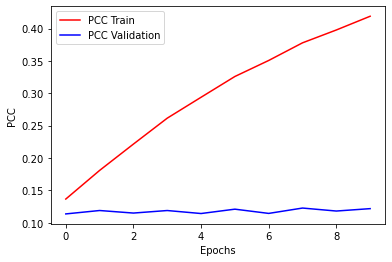

In [26]:
from sklearn.metrics import mean_squared_error
# Data
# train_data,valid_data,test_data
# train_targ,valid_targ,test_targ

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
      
    ## Batchnorm
    Batchnorm = nn.BatchNorm1d(100)
    
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        t = train_data[slce]
        t = torch.transpose(t,1,2)
        output = net(t)
        
        output = Batchnorm(output)
                
        # compute gradients given loss
        target_batch = train_targ[slce]
        
        #print("output: ",output.shape)
        #print("target: ",target_batch.shape)
        
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        t = train_data[slce]
        t = torch.transpose(t,1,2)
        output = net(t)

        train_targs += list(train_targ[slce].numpy())
        train_preds += list(output.data.numpy())
    
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        v = valid_data[slce]
        v = torch.transpose(v,1,2)
        output = net(v)
        
        val_targs += list(valid_targ[slce].numpy())
        val_preds += list(output.data.numpy())
        
    
    train_targs = np.concatenate(train_targs)
    train_preds = np.concatenate(train_preds)
    val_targs = np.concatenate(val_targs)
    val_preds = np.concatenate(val_preds)
    
    train_acc_cur = np.abs((np.cov(train_targs,train_preds)[0,1])/(np.std(train_targs)*np.std(train_preds)))
    valid_acc_cur = np.abs((np.cov(val_targs,val_preds)[0,1])/(np.std(val_targs)*np.std(val_preds)))
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    
    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
        epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
    
    
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['PCC Train','PCC Validation'])
plt.xlabel('Epochs'), plt.ylabel('PCC')

In [28]:
# Using the model on the test data
v = torch.transpose(test_data,1,2)
output_test = net(v)

tst_preds, tst_targs = [], []
tst_targs += list(test_targ.numpy())
tst_preds += list(output_test.data.numpy())

tst_targs = np.concatenate(tst_targs)
tst_preds = np.concatenate(tst_preds)

test_acc = abs((np.cov(tst_targs,tst_preds)[0,1])/(np.std(tst_targs)*np.std(tst_preds)))
print(test_acc)

0.06367431628390229
